In [1]:
import sys

sys.path.append(r"C:\Users\prabr\AppData\Local\Programs\Python\Python313\Lib\site-packages")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("crane_temp_rain_tree_pop_veg_turbine_2001-2020.csv")
data = data[data["OBSERVATION COUNT"]!="X"]
data = data.dropna()
data = data.drop(columns=["GLOBAL UNIQUE IDENTIFIER","COUNTRY","country"]).sort_values(["OBSERVATION DATE","TIME OBSERVATIONS STARTED"])
data["Temp"] = data["OBSERVATION COUNT"].shift(-1)
data["Temp2"] = data["Temp"]>data["OBSERVATION COUNT"]
data = data.drop(columns=["Temp"])
data["OBSERVATION DATE"]=pd.to_datetime(data["OBSERVATION DATE"],utc=True)
data["Year"]=data["OBSERVATION DATE"].dt.year
data["Month"]=data["OBSERVATION DATE"].dt.month
data["Day"]=data["OBSERVATION DATE"].dt.day
data["TIME OBSERVATIONS STARTED"]=pd.to_datetime(data["TIME OBSERVATIONS STARTED"])
data["Minute"] = data["TIME OBSERVATIONS STARTED"].dt.minute
data["Hour"] = data["TIME OBSERVATIONS STARTED"].dt.hour
data = data.drop(columns=["TIME OBSERVATIONS STARTED","OBSERVATION DATE"])
answers = data["Temp2"]
data["OBSERVATION COUNT"] = data["OBSERVATION COUNT"].astype("int32")
data = data.drop(columns="Temp2")
data

C:\Users\prabr\AppData\Local\Temp\ipykernel_3716\3415210502.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["TIME OBSERVATIONS STARTED"]=pd.to_datetime(data["TIME OBSERVATIONS STARTED"])


,OBSERVATION COUNT,LATITUDE,LONGITUDE,DURATION MINUTES,AVERAGE MONTH TEMPERATURE,AVERAGE MONTH RAINFALL,tree_loss_ha,percentage_loss,Population,NDVI,WT_COUNT_10KM_RADIUS,Year,Month,Day,Minute,Hour
336,1,29.323448,47.831254,30.0,12.47,22.96,0,0.000000,1.995150e+06,0.076,0.0,2001,1,4,0,11
96,272,39.138914,-3.704686,2.0,7.25,116.37,32811,0.064838,4.132798e+07,0.348,0.0,2001,1,13,15,21
213,1,29.328382,47.830203,60.0,12.47,22.96,0,0.000000,1.995150e+06,0.060,0.0,2001,1,18,0,6
226,19,29.186301,116.018493,480.0,-7.38,18.89,230289,0.024545,1.279518e+09,0.192,55.0,2001,1,18,45,7
335,1,29.323448,47.831254,90.0,12.47,22.96,0,0.000000,1.995150e+06,0.076,0.0,2001,1,18,30,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75227,7,62.132530,21.331301,63.0,15.66,56.39,254473,0.755249,5.496198e+06,0.760,0.0,2020,6,30,20,20
82552,4,60.393950,22.460830,21.0,15.66,56.39,254473,0.755249,5.496198e+06,0.536,0.0,2020,6,30,48,20
82580,4,60.393950,22.460830,21.0,15.66,56.39,254473,0.755249,5.496198e+06,0.536,0.0,2020,6,30,48,20
75685,2,64.272515,23.834603,19.0,15.66,56.39,254473,0.755249,5.496198e+06,0.228,0.0,2020,6,30,22,21


In [4]:
data_tilde = (data - data.mean()).to_numpy()

In [5]:
U, sigma, V_t=np.linalg.svd(data_tilde.T)

In [6]:
dim_2 = np.dot(U[:,:2].T,data_tilde.T)
dim_3 = np.dot(U[:,:3].T,data_tilde.T)

In [7]:
dim_2_df=pd.DataFrame(dim_2.T,columns=["PC1","PC2"])
dim_3_df=pd.DataFrame(dim_3.T,columns=["PC1","PC2","PC3"])

In [8]:
dim_2_df["Label"] = answers.values
dim_3_df["Label"] = answers.values

<Axes: xlabel='PC1', ylabel='PC2'>

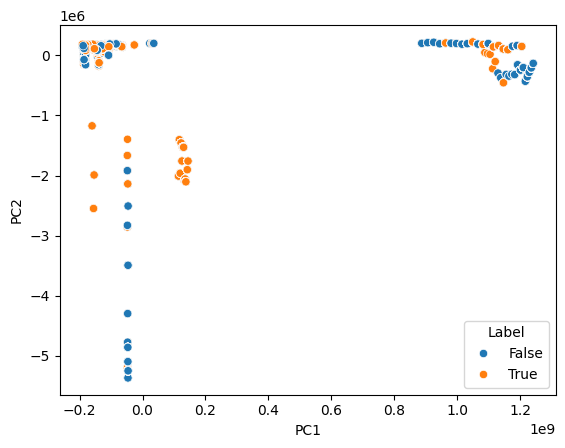

In [9]:
sns.scatterplot(dim_2_df,x="PC1",y="PC2",hue="Label")

Text(0.5, 0, 'PC 3')

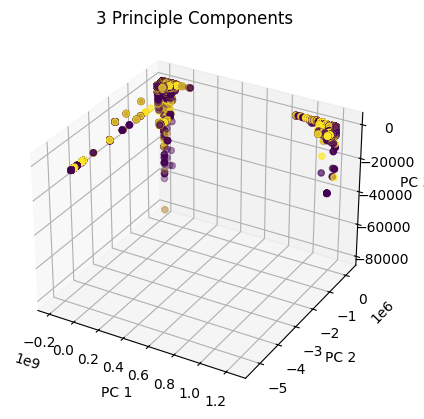

In [10]:
fig = plt.figure()

ax = fig.add_subplot(111,projection="3d")
plt.title("3 Principle Components")

ax.scatter(xs=dim_3_df["PC1"],ys=dim_3_df["PC2"],zs=dim_3_df["PC3"],c=dim_3_df["Label"])
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')


In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

score = []

def xg(training_data):

    for i in range(300):
            X_train, X_test, y_train, y_test = train_test_split(training_data, dim_2_df["Label"], test_size=.2)

            bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

            bst.fit(X_train, y_train)
            # make predictions
            preds = bst.predict(X_test)
            score.append(((preds==y_test).sum()/preds.size)*100)
    print("Accuracy for 1 principle component: ",round(np.mean(score),2))


xg(dim_3_df[["PC1"]])
xg(dim_3_df[["PC1","PC2"]])
xg(dim_3_df[["PC1","PC2","PC3"]])

Accuracy for 1 principle component:  61.76
Accuracy for 1 principle component:  61.78
Accuracy for 1 principle component:  61.8


Accuracy seems to be fairly consistent for 3 principle components

In [12]:
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap
import warnings
warnings.filterwarnings("ignore")

samples = 30000

X = data.to_numpy()
embedding = Isomap(n_components=2)
X_transformed_2 = embedding.fit_transform(X[:samples])

embedding = Isomap(n_components=3)
X_transformed_3 = embedding.fit_transform(X[:samples])


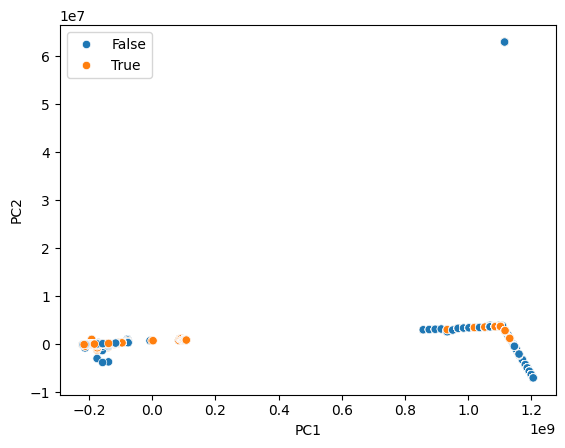

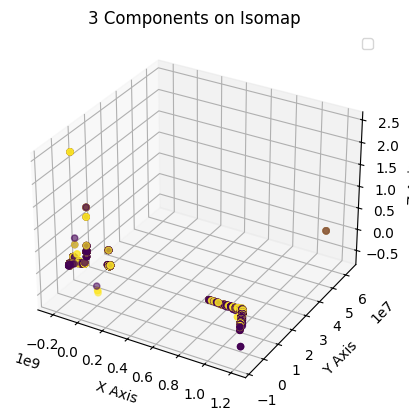

In [13]:
dim_2_df=pd.DataFrame(X_transformed_2,columns=["PC1","PC2"])
dim_3_df=pd.DataFrame(X_transformed_3,columns=["PC1","PC2","PC3"])
dim_2_df["Label"] = answers[:samples].values
dim_3_df["Label"] = answers[:samples].values

plt.figure()
sns.scatterplot(dim_2_df,x="PC1",y="PC2",hue="Label")
plt.legend()

fig = plt.figure()

ax = fig.add_subplot(111,projection="3d")

plt.title("3 Components on Isomap")
ax.scatter(xs=dim_3_df["PC1"],ys=dim_3_df["PC2"],zs=dim_3_df["PC3"],c=dim_3_df["Label"])
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
plt.legend()

In [14]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

score = []

def xg(training_data):

    for i in range(300):
            X_train, X_test, y_train, y_test = train_test_split(training_data, dim_2_df["Label"], test_size=.2)

            bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

            bst.fit(X_train, y_train)
            # make predictions
            preds = bst.predict(X_test)
            score.append(((preds==y_test).sum()/preds.size)*100)
    print("Accuracy for 1 principle component: ",round(np.mean(score),2))


xg(dim_3_df[["PC1"]])
xg(dim_3_df[["PC1","PC2"]])
xg(dim_3_df[["PC1","PC2","PC3"]])

Accuracy for 1 principle component:  61.42
Accuracy for 1 principle component:  61.46
Accuracy for 1 principle component:  61.44
